In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [10]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

training examples = 2500, testing examples = 325


## Model-Building and Evaluation

In [4]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=train_df["prob_of_release"],
                       lower=0, upper=1, shape=features.shape[1])

In [5]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 565 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [6]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.11,0.58,-0.93,1.26,0.02,0.01,953.27,1569.39,1.0
WD_Thursday,0.05,0.03,-0.00,0.10,0.00,0.00,1391.73,2203.06,1.0
WD_Wednesday,0.04,0.03,-0.01,0.09,0.00,0.00,1201.27,2080.93,1.0
month_holidays,0.01,0.01,-0.00,0.02,0.00,0.00,3347.31,2581.68,1.0
previous_days_since_previous_release,0.01,0.58,-1.15,1.04,0.02,0.01,952.47,1575.72,1.0
WD_Tuesday,-0.01,0.03,-0.06,0.04,0.00,0.00,1090.90,1547.78,1.0
WD_Monday,-0.07,0.03,-0.12,-0.02,0.00,0.00,1175.32,1939.21,1.0
WD_Saturday,-0.07,0.03,-0.12,-0.02,0.00,0.00,1256.15,2150.39,1.0
WD_Sunday,-0.09,0.03,-0.13,-0.04,0.00,0.00,1136.80,1920.46,1.0


### Out-of-Sample Evaluation

In [7]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [11]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [12]:
mape(test_df["prob_of_release"], y_pred)

0.25513942123480515

In [13]:
wape(test_df["prob_of_release"], y_pred)

0.2329423537673254

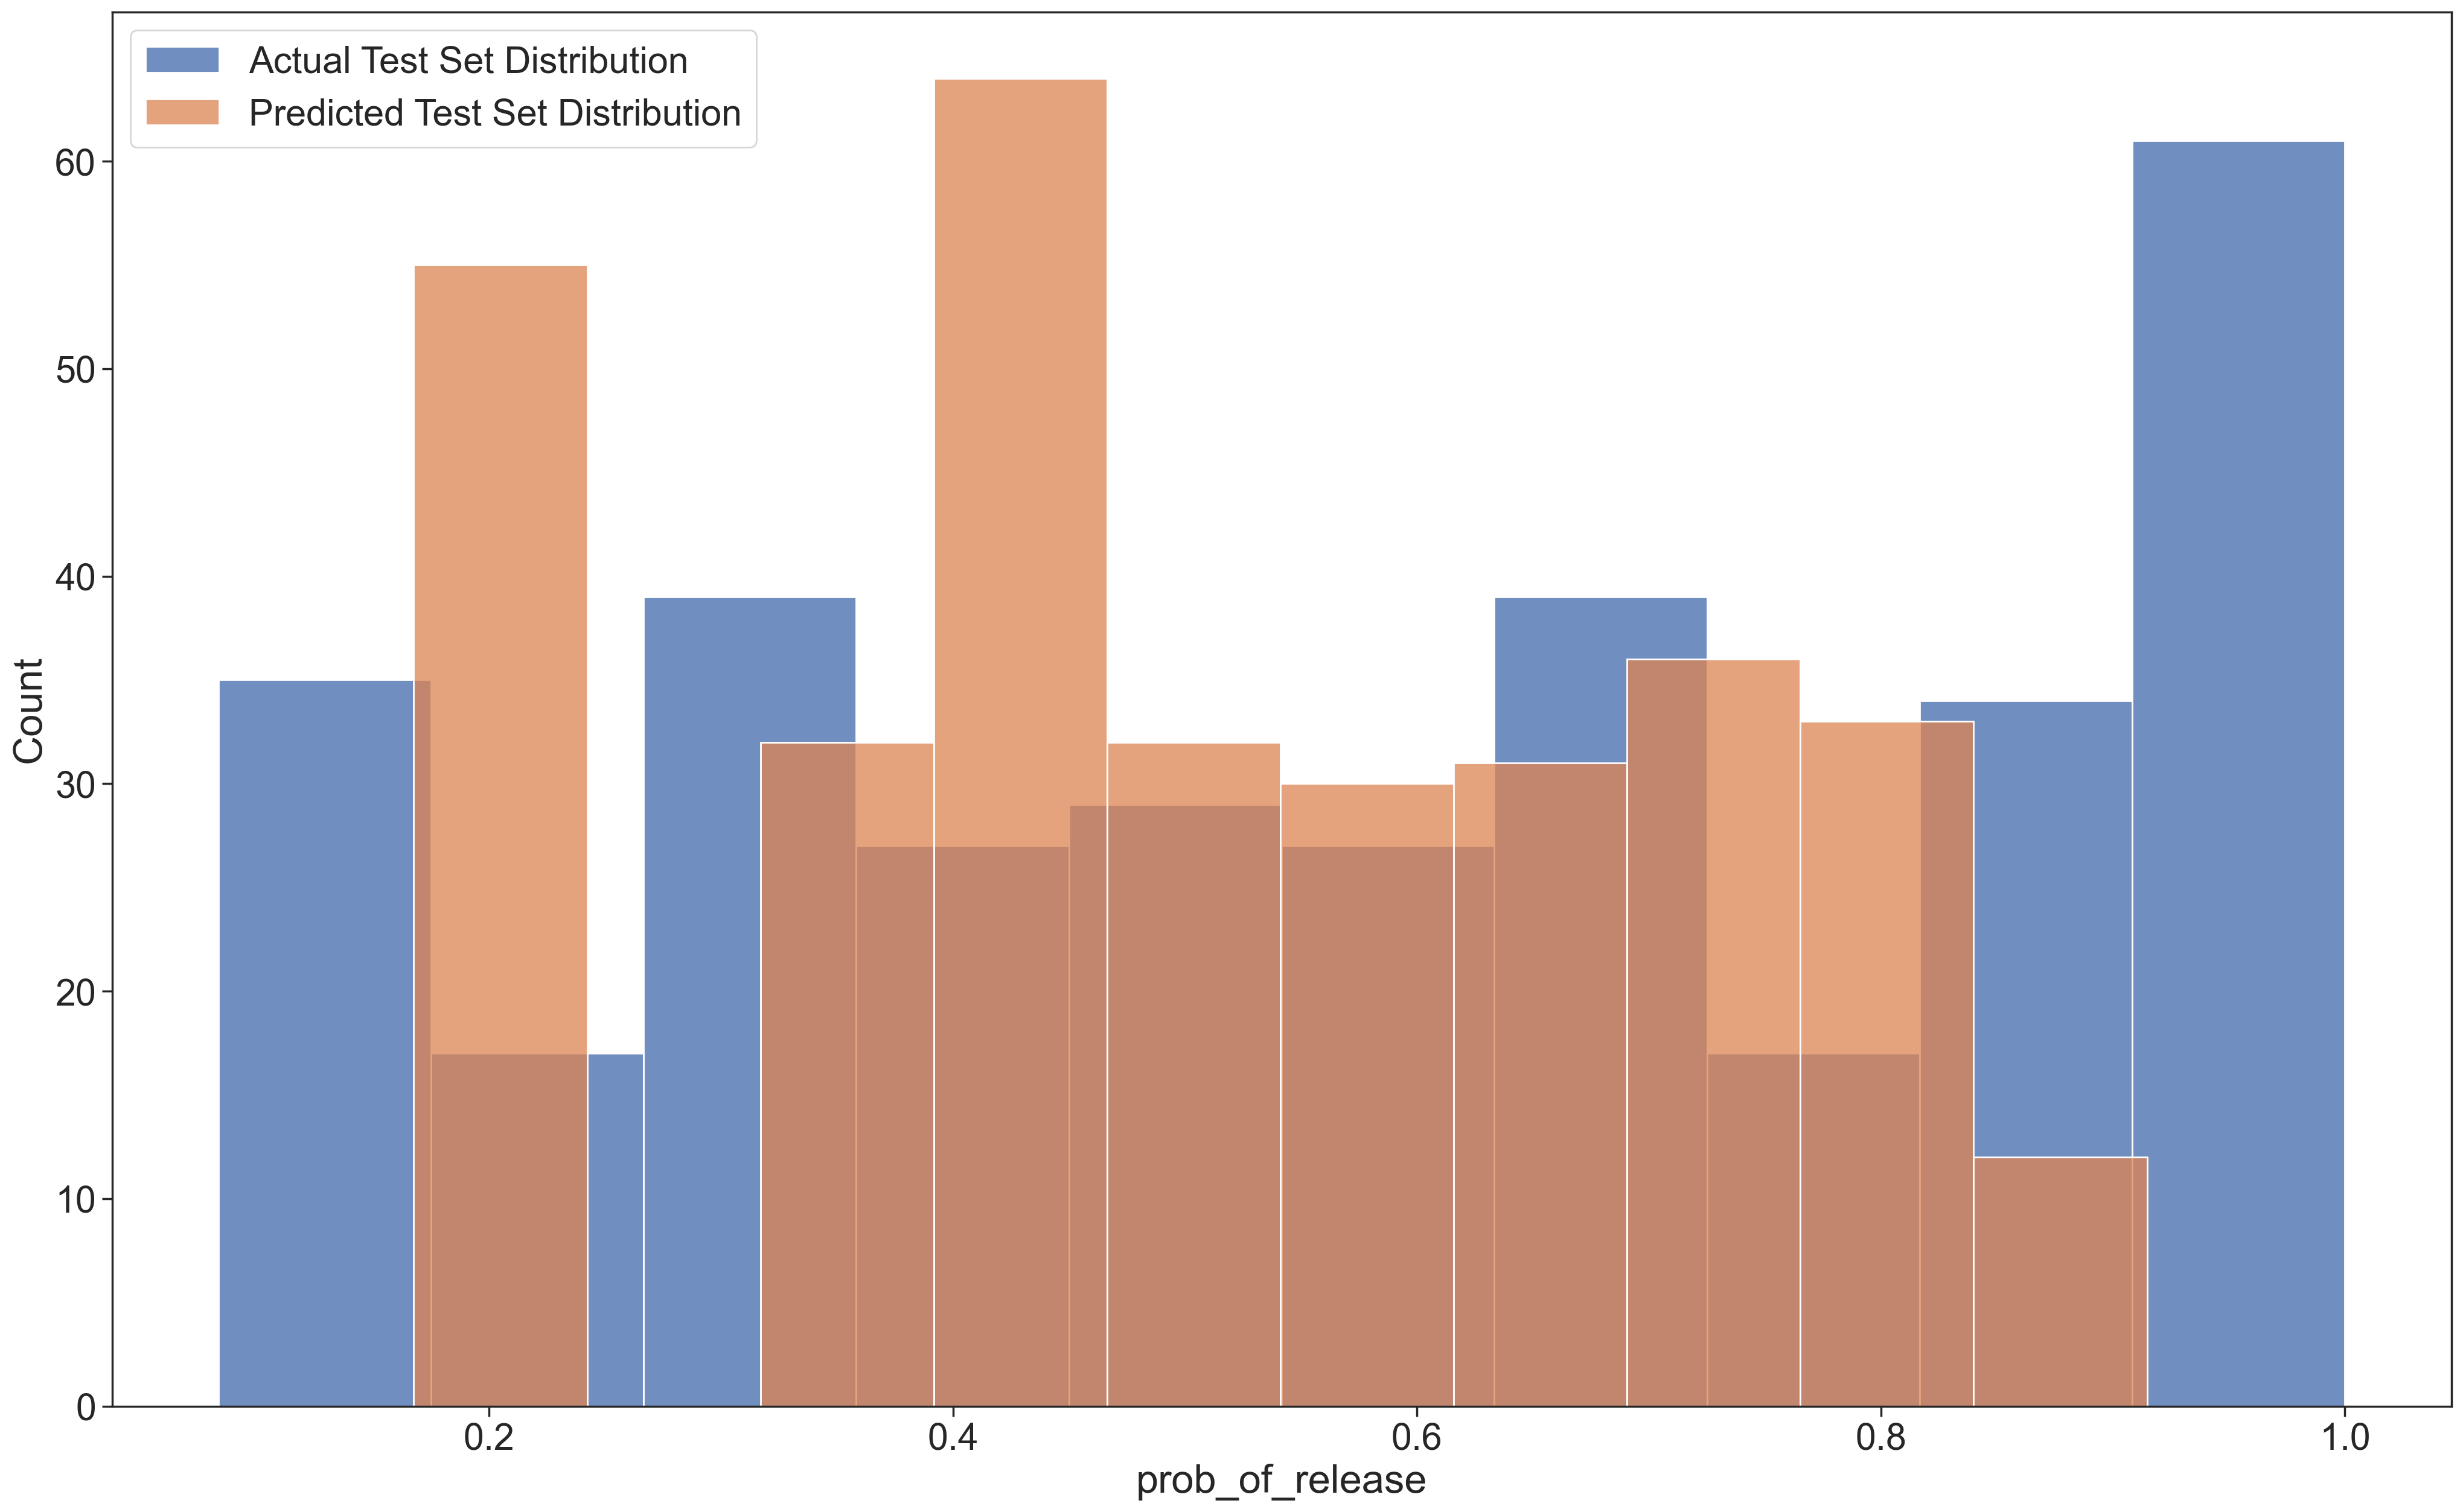

In [14]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=y_pred, ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Two Weeks

In [17]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [18]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1157 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [19]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,0.14,0.59,-0.92,1.25,0.02,0.01,854.53,1635.57,1.00
WD_Thursday,0.04,0.03,-0.01,0.09,0.00,0.00,909.07,1959.55,1.00
WD_Wednesday,0.03,0.03,-0.02,0.08,0.00,0.00,901.20,1825.69,1.01
month_holidays,0.00,0.01,-0.01,0.01,0.00,0.00,2907.14,2677.47,1.00
WD_Tuesday,-0.02,0.03,-0.07,0.03,0.00,0.00,880.22,1564.51,1.01
previous_days_since_previous_release,-0.03,0.59,-1.14,1.03,0.02,0.01,854.92,1615.16,1.01
WD_Monday,-0.09,0.03,-0.13,-0.04,0.00,0.00,805.09,1660.27,1.00
WD_Saturday,-0.10,0.03,-0.15,-0.05,0.00,0.00,876.90,1508.22,1.00
WD_Sunday,-0.12,0.03,-0.16,-0.07,0.00,0.00,857.65,1608.60,1.01


In [25]:
with model:
    pm.set_data({"features" : next_two_weeks[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [26]:
next_two_weeks["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [27]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_two_weeks["predicted_min"] = hdi["y_pred"][:, 0]
next_two_weeks["predicted_max"] = hdi["y_pred"][:, 1]

In [28]:
next_two_weeks[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
0,2024-11-21,0.0000,0.2193,0.5242
1,2024-11-22,0.0064,0.4389,0.8247
2,2024-11-23,0.0203,0.4451,0.8436
3,2024-11-24,0.1099,0.5194,0.9604
4,2024-11-25,0.2463,0.6276,0.9984
5,2024-11-26,0.4131,0.7361,1.0000
6,2024-11-27,0.5160,0.8051,1.0000
7,2024-11-28,0.5912,0.8424,0.9999
8,2024-11-29,0.6277,0.8587,1.0000
9,2024-11-30,0.6208,0.8576,1.0000


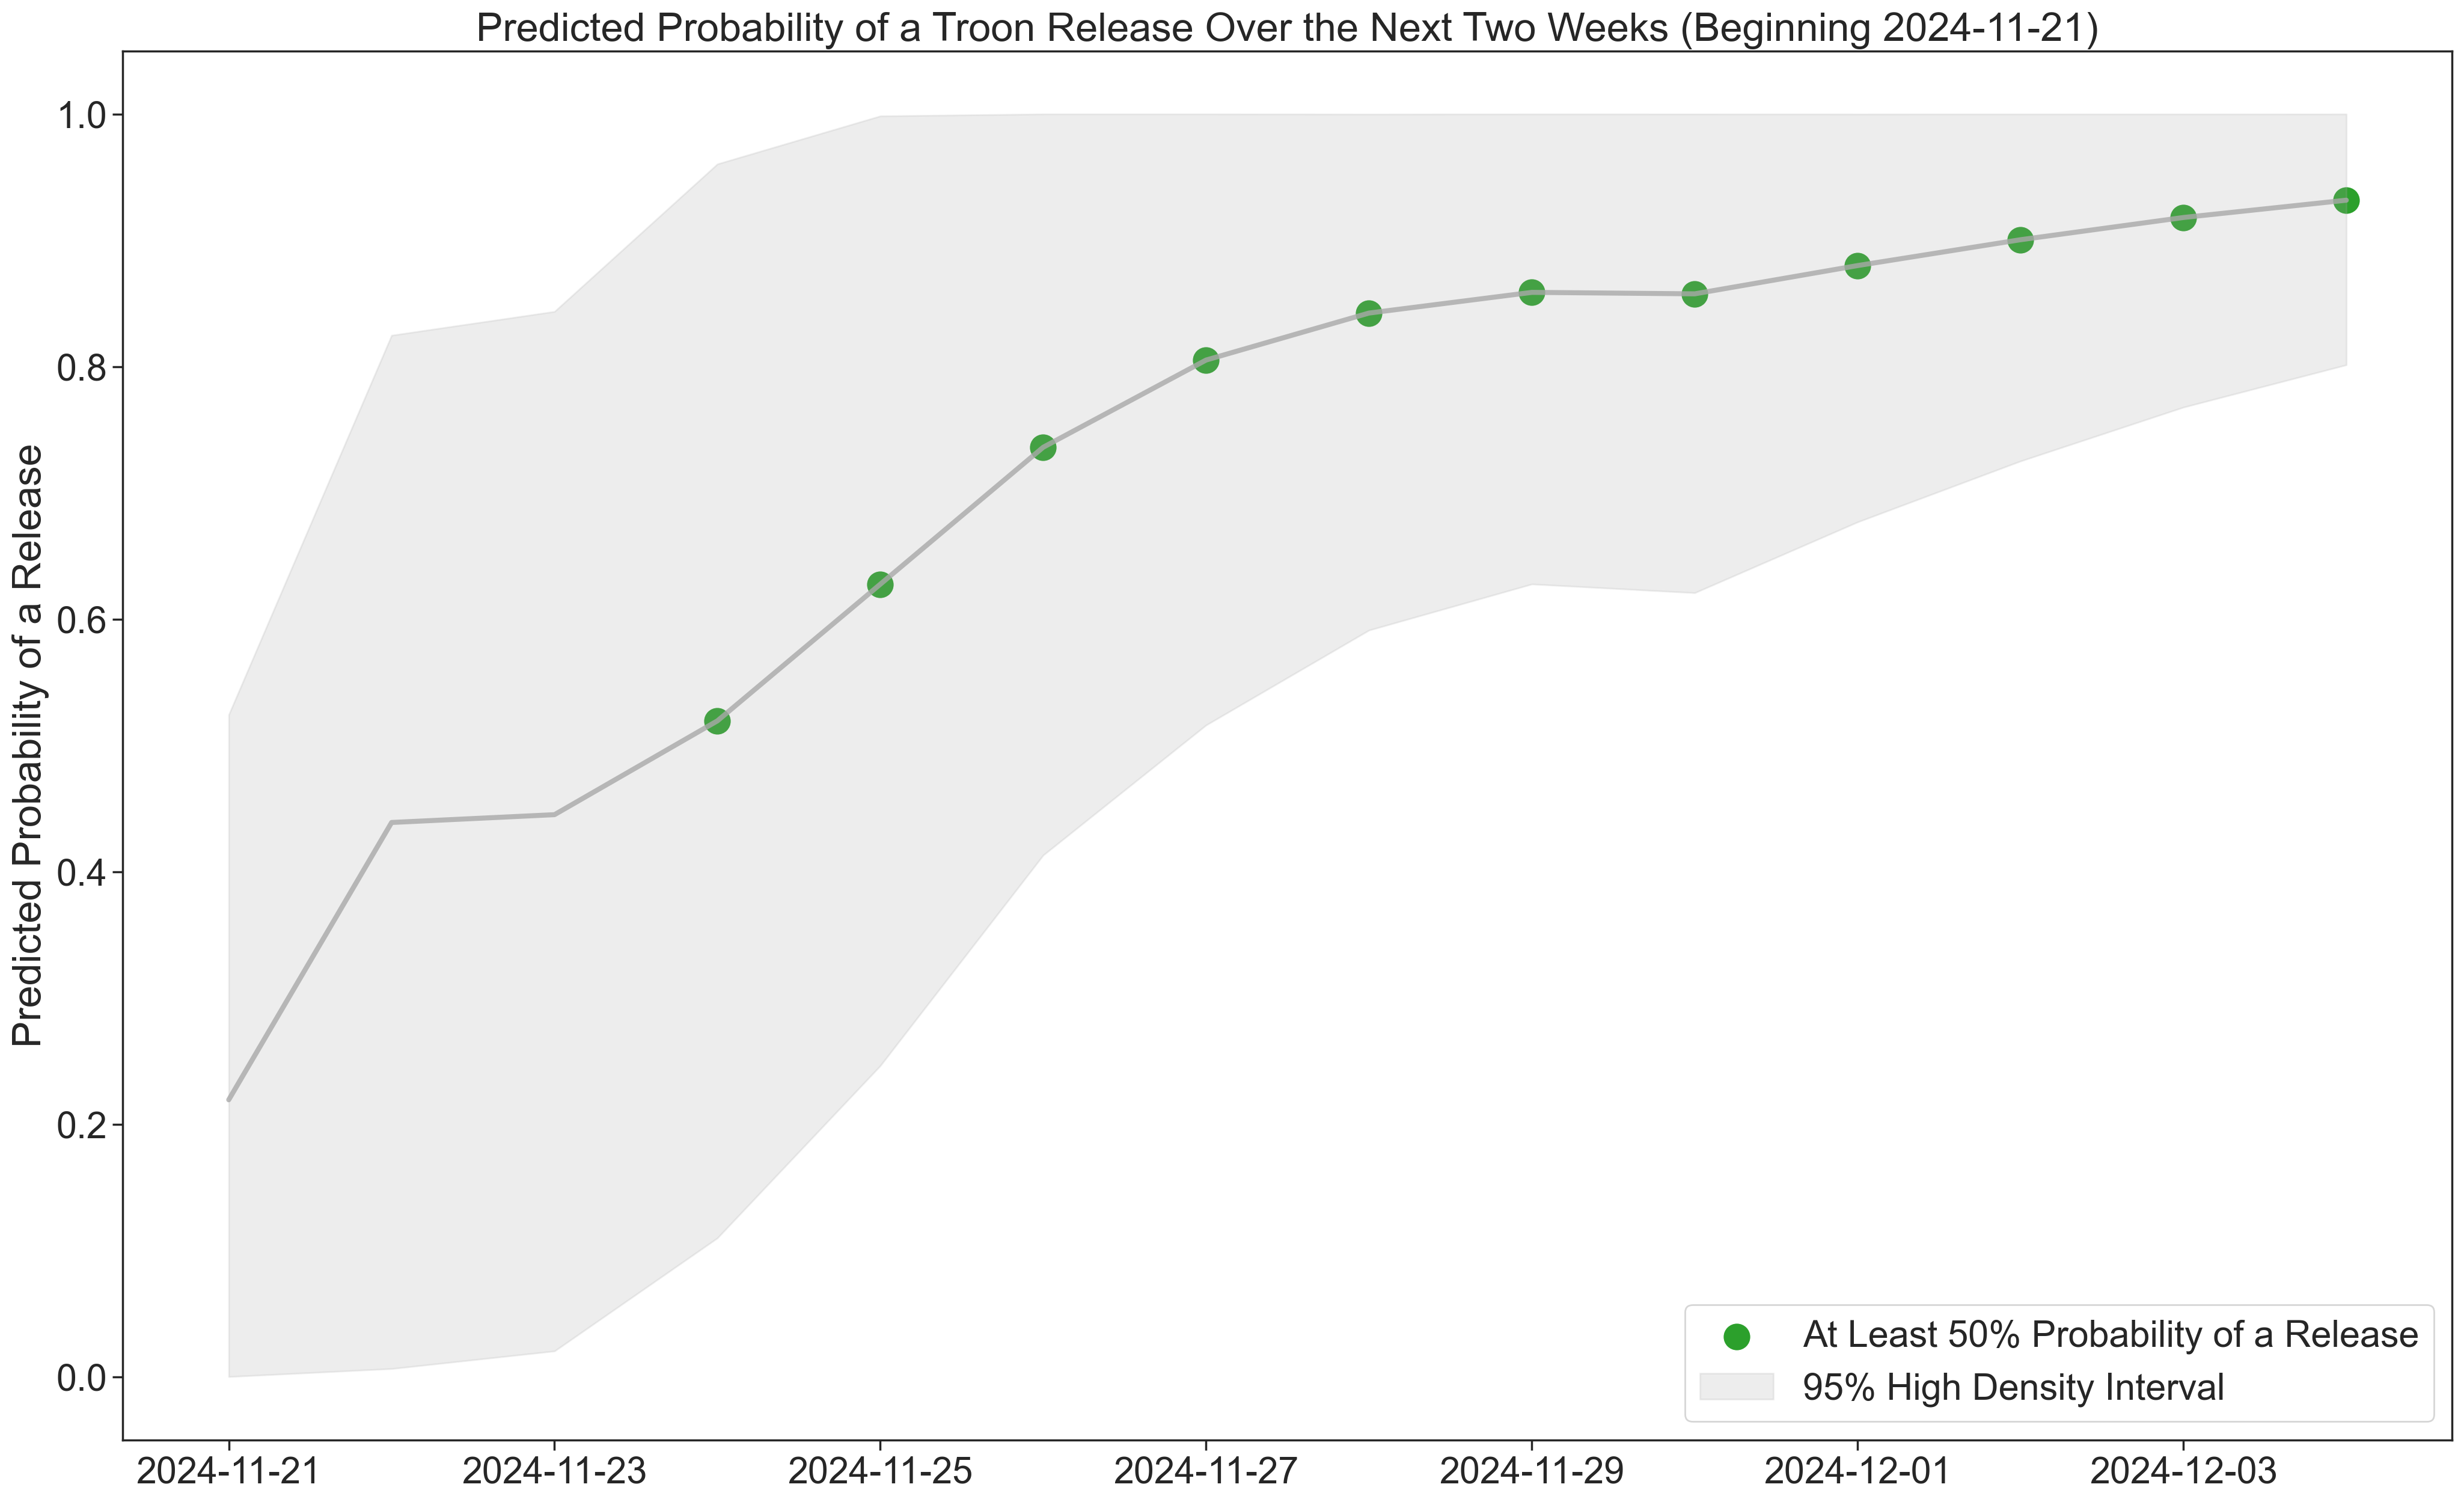

In [29]:
ax = sns.lineplot(data=next_two_weeks, x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_two_weeks[next_two_weeks["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_two_weeks["index"],
                y1=next_two_weeks["predicted_min"],
                y2=next_two_weeks["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()